In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from ml_utils import costs, grid_search

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [21]:
def least_squares(y, tx):
    """
    Least squares regression using normal equations
    
    :param y: Labels
    :param tx: Feature matrix
    :return: weights, loss
    """
    left = tx.T.dot(y)
    right = tx.T.dot(tx)
    return np.linalg.solve(left, right)

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [24]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    # ***************************************************
    ls_w, ls_loss = least_squares(y, tx)
    grid_w0, grid_w1 = grid_search.generate_w(num_intervals=100)
    grid_losses = grid_search.grid_search(y, tx, grid_w0, grid_w1)
    grid_loss, grid_w0, grid_w1 = grid_search.get_best_parameters(grid_w0, grid_w1, grid_losses)
    grid_w = np.array([grid_w0, grid_w1])
    
    print("Got loss={} for Least Squares (w={}), and loss={} for Grid Search (w={})".format(ls_loss, ls_w, grid_loss, grid_w))

Test it here

In [25]:
test_your_least_squares()

(10000,)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    tiled = np.tile(np.vstack(x), degree+1)
    poly = np.power(tiled, np.arange(degree + 1))
    return poly

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
        # ***************************************************
        poly = build_poly(x, degree)
        weights, loss = least_squares(y, poly)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        # ***************************************************
        rmse = costs.compute_rmse_loss(y, poly, weights)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

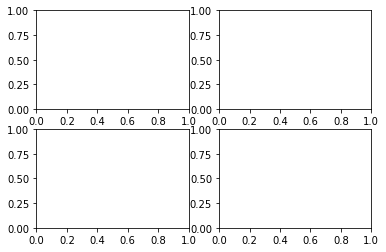

In [8]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [9]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    indices = np.random.permutation(x.shape[0])
    num_train = int(ratio * x.shape[0])
    train_indices, test_indices = indices[:num_train], indices[num_train:]
    assert (len(train_indices) + len(test_indices)) == len(indices)    
    train_x, train_y = x[train_indices], y[train_indices]
    test_x, test_y = x[test_indices], y[test_indices]
    return train_x, train_y, test_x, test_y

Then, test your `split_data` function below.

In [10]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed=seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_x, test_x = build_poly(train_x, degree), build_poly(test_x, degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calcualte weight through least square.: TODO
    # ***************************************************
    weights, mse_loss = least_squares(train_y, train_x)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_tr, rmse_te = costs.compute_rmse_loss(train_y, train_x, weights), costs.compute_rmse_loss(test_y, test_x, weights)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [11]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

# 3 Ridge Regression
Please fill in the function below.

In [12]:
def ridge_regression(y, tx, lambda_):
    """
    Ridge regression using normal equations
    
    :param y: Labels
    :param tx: Feature matrix
    :param lambda_: Regularization parameter
    :return: weights, loss
    """
    N, D = tx.shape
    aI = (2*N * lambda_) * np.identity(D)
    left = tx.T.dot(tx) + aI
    right = tx.T.dot(y)
    return np.linalg.solve(left, right)


In [13]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    train_x, train_y, test_x, test_y = split_data(x, y, ratio=ratio, seed=seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_x, test_x = build_poly(train_x, degree), build_poly(test_x, degree)
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        w_star = ridge_regression(train_y, train_x, lambda_)
        rmse_train, rmse_test = costs.compute_rmse_loss(train_y, train_x, w_star), costs.compute_rmse_loss(test_y, test_x, w_star)
        rmse_tr.append(rmse_train)
        rmse_te.append(rmse_test)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

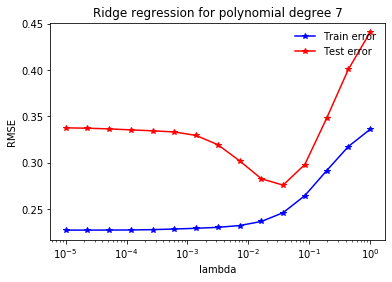

In [190]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)